# Block 9: Logistic Regression

In [10]:
import numpy as np 
import pandas as pd 
from typing import List
import jax.numpy as jnp 
import jax
import matplotlib.pyplot as plt
import sklearn.metrics

In [14]:
def prepare_inputs(input_df):
    """
        Prepares the input features that will be fed into the model.

        Inputs:
            input_df: the input dataframe into the function. Should consist ONLY of input features.
        Outputs:
            Z: the input feature matrix of size NxK, where K is the number of features
    """
    # Let's identify categorical columns in a dataframe
    categorical_cols = input_df.select_dtypes(include='object').columns
    
    # Let's identify the numeric columns in the dataframe
    numeric_cols = input_df.select_dtypes(include='number').columns

    # We want to construct the input features into the model
    # We will use a numpy array that contains both numeric and categorically encoded values
    X = input_df[numeric_cols].to_numpy() # (NxK)
    
    # Now we need to z-score the numeric features so that they can lead to efficient learning
    col_means = np.mean(X, axis=0) # K
    col_stds = np.std(X, axis=0, ddof=1) # K
    
    # Z-score
    # (NxK - 
    #  1xK) 
    #  / 
    #  (1xK)
    Z = (X - col_means[None, :]) / col_stds[None, :]
    
    # Now we want to code the categorical columns using one-hot encoding
    for col in categorical_cols:
        # NxC (C is the number of unique values in the column)
        # So for origin this will be Nx3 
        dummies = pd.get_dummies( input_df[col] ).to_numpy() 
        
        # concatenate dummies matrix onto Z
        #print(Z.shape)
        #print(dummies.shape)
        Z = np.hstack((Z, dummies)) 
    
    # finally we want to add a column of ones at the start of Z
    ones_col = np.ones((Z.shape[0], 1)) # Nx1
    
    Z = np.hstack((ones_col, Z))

    return Z

@jax.jit # <-- JAX
def forward_fn(Beta, Z):
    """
        Logistic regression forward function.
        Implements the equation f(x) = b0 + b1 * x1 + b2 * x2 + ...
                                y(x) = sigmoid(f(x))
        Inputs:
            Beta: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
        Output:
            yhat: the model's predictions (size N)
    """
    f = Z @ Beta 
    p = 1/(1+jnp.exp(-f))
    return p 

def predict(Beta, input_df):
    """
        Convienience function that prepares inputs and runs the forward function.

        Inputs:
            Beta: the coefficients of the model (size K)
            input_df: input data frame (input features only, no output column).
        Output:
            yhat: the model's predictions (size N)
    """
    Z = prepare_inputs(input_df)
    return forward_fn(Beta, Z)

@jax.jit # <-- JAX
def loss_fn(Beta, Z, y):
    """
        Computes the negative cross-entropy loss function for the model.

        Inputs:
            Beta: the coefficients of the model (size K)
            Z: the input feature matrix, as returned by prepare_inputs (size NxK)
            y: actual observations (size N)
        Output:
            loss: negative binary cross entropy
    """
    yhat = forward_fn(Beta, Z)
    loss = -jnp.mean(y * jnp.log(yhat) + (1-y) * jnp.log(1-yhat))
    return loss 

def optimize(rng, input_df, y, learning_rate, epochs):
    """
        Input parameters:
            rng: JAX random key
            input_df: dataframe containing input columns
            y: a vector of outputs that we wish to predict
            learning_rate: how quickly we want gradient descent learning
            epochs: the number of steps of gradient descent
        Output:
            Beta: fitted model parameters
    """
    
    # move y into jax's domain
    y = jnp.array(y) # <-- JAX

    # Create a function that computes the gradient of the loss_fn with respect to the first argument (Beta)
    grad_fn = jax.grad(loss_fn) # <-- JAX

    # Prepare our inputs into the linear regression
    Z = prepare_inputs(input_df) # NxK

    # Randomly initialize our solution
    Beta = jax.random.normal(key = rng, shape=Z.shape[1]) # <-- JAX
    
    # Run gradient descent loop
    for i in range(epochs):

        # compute gradient
        # this is very powerful ... JAX takes care of derivative computation
        # so loss_fn (and forward_fn) could be as complex as you like
        # as long as they are reasonably continous
        Beta_grad = grad_fn(Beta, Z, y) # <-- JAX
        
        # Update the parameters
        Beta = Beta - learning_rate * Beta_grad

    # Beta is the fitted parameter values
    return Beta

# We will create little function that takes the training dataframe and the testing dataframe
# and returns MSE on test
def lr_train_test_function(rng, train_df, test_df, input_cols, output_col):

    # build the training input data frame
    train_input_df = train_df[input_cols]

    # build the training outputs
    y = train_df[output_col].to_numpy()
    
    # Optimize the model using gradient descent
    best_Beta = optimize(rng,
                         input_df = train_input_df,
                         y = y,
                         learning_rate = 0.1,
                         epochs = 100)

    # build the testing input data frame
    test_input_df = test_df[input_cols]

    # Make predictions on the test set
    yhat = predict(Beta = best_Beta,
                   input_df = test_input_df)
    
    # Calculate error of those predictions
    ytest = test_df[output_col].to_numpy()
    
    # we'll use accuracy for now
    return sklearn.metrics.accuracy_score(ytest, yhat > 0.5)


In [24]:
df = pd.read_csv("../data/separable_binary_data.csv")
df

rng = jax.random.key(42)

accuracy = lr_train_test_function(rng,
                                  train_df=df,
                                  test_df=df,
                                  input_cols=['x1','x2'],
                                  output_col='y')
accuracy

0.995

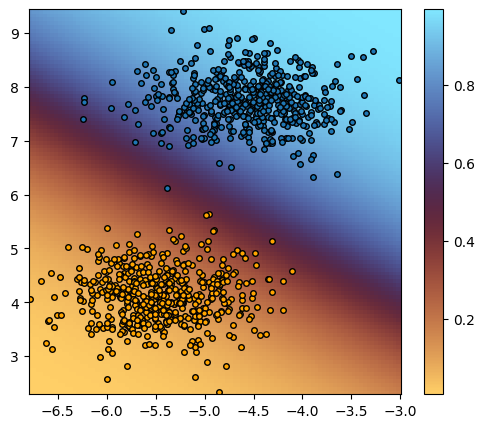

In [25]:
# Optimize the model using gradient descent
best_Beta = optimize(rng,
                     input_df = df[['x1','x2']],
                     y = df.y.to_numpy(),
                     learning_rate = 0.1,
                     epochs = 100)

# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = predict(Beta = best_Beta, input_df = df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)


# A Hard Example

In [26]:
df = pd.read_csv("../data/nonseparable_binary_data.csv")
df

rng = jax.random.key(42)

accuracy = lr_train_test_function(rng,
                                  train_df=df,
                                  test_df=df,
                                  input_cols=['x1','x2'],
                                  output_col='y')
accuracy

0.553

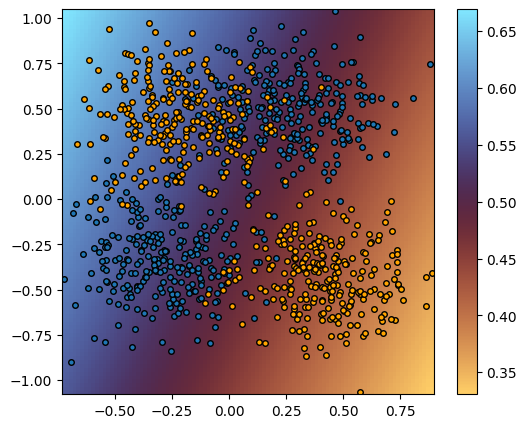

In [9]:
# initialize range of input values

min_x = np.min(df[['x1', 'x2']].to_numpy(), axis=0)
max_x = np.max(df[['x1', 'x2']].to_numpy(), axis=0)

K = 100
x1s = np.linspace(min_x[0], max_x[0], K)
x2s = np.linspace(min_x[1], max_x[1], K)
x1s, x2s = np.meshgrid(x1s, x2s)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T

df_star = pd.DataFrame(data=Xstar, columns=['x1','x2'])

yhat = model.predict(df_star).reshape((K,K))

f, ax = plt.subplots(1, 1, figsize=(6, 5))

cp = ax.pcolor(x1s, x2s, yhat, cmap=plt.get_cmap('managua')) # 0: orange, 1: blue
f.colorbar(cp)

#
# plot the actual points
#
X = df[['x1','x2']].to_numpy()

y = df['y'].to_numpy()
class0_ix = y == 1 # y = 1, blue
class1_ix = y == 0 # y = 0, orange

ax.plot(X[class0_ix, 0], X[class0_ix, 1], marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)
ax.plot(X[class1_ix, 0], X[class1_ix, 1], color='orange', marker='o', markersize=4, linestyle='', markeredgecolor='black', markeredgewidth=1)


# Quick Exercise: Use our CV to Evaluate

In [37]:
def cv(df, train_test_fn, folds, random_state):
    """
        Cross-validation: splits dataset into N folds, repeatedly trains on N-1 folds and test on the remaining.

        Inputs:
            df: dataframe of inputs and outputs
            train_test_fn: the training and testing function used
            folds: number of folds
            random_state: pseudo random number generator state
        Output:
            metrics: loss on each split (size N)
    
    """
    # instantiate the splitter
    kf = sklearn.model_selection.KFold(n_splits=folds, 
                                       shuffle=True, 
                                       random_state=random_state)
    
    metrics = []
    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        
        # evaluate
        metric = train_test_fn(train_df, test_df)
        metrics.append(metric)
    
    return metrics 

def factory(input_cols, output_col):
    def train_test_fn(train_df, test_df):
        rng = jax.random.key(8758)
        return lr_train_test_function(rng,
                                      train_df=train_df,
                                      test_df=test_df,
                                      input_cols=input_cols,
                                      output_col=output_col)
    return train_test_fn

df = pd.read_csv("../data/separable_binary_data.csv")
train_test_fn = factory(['x1','x2'],'y')
cv(df = df, train_test_fn=train_test_fn, folds=5, random_state=14234)

[0.98, 0.985, 0.985, 0.97, 0.985]